# Modelo de Pairs Trading Baseado em Cointegração

**Autores: Alexandre Fernandes Theoharidis, Débora Darin e Nelly Pires Colnaghi**

**Este trabalho contém:**

**1)** Importação da série de preços das ações PETR3 e PETR4 e tratamento de dados;

**2)** Cálculo da regressão linear dos preços das ações & computação dos resíduos da regressão (spreads) para verificação de desvios da média;

**3)** Backtest da estratégia de pairs trading;

**4)** Cálculo do retorno para o par PETR3 x PETR4.

## Introdução

Neste notebook, foi desenvolvido um modelo de pairs trading de ações baseado em cointegração, inspirado no artigo de Caldeira e Moura (2013). A estratégia tem como objetivo identificar, no curto prazo, desvios entre preços de pares de ativos que estejam relacionados no longo prazo. Assim, A cointegração se verifica quando os resíduos de um modelo de regressão entre duas séries são estacionários - dessa forma, dizemos que as séries são cointegradas.

Assim, a primeira etapa da estratégia resume-se a encontrar um par de ações com spread estacionário. Matematicamente, sejam $A_t$ e $B_t$, $t = 1, 2,…, T$, a série de preços das ações A e B, respectivamente. Uma abordagem simples para verificar se essas ações são elegíveis consiste no seguinte modelo de regressão (1):

\begin{align}
ln A_t = \alpha + \beta ln B_t + \varepsilon_t
\end{align}

onde $\varepsilon_t$ é o spread do par, $\beta$ é a proporção do ativo A em relação ao ativo B e $\alpha$ é uma constante. Teoricamente, o spread deve ter média zero. Os log preços dos ativos são usados em vez dos seus preços de mercado, de modo a impor uma relação entre os retornos desses ativos, semelhante aos modelos de fatores aplicado aos retornos das ações, como os introduzidos por Carhart (1997) e Fama e French (1993), relacionando o retorno esperado da ação A ao retorno esperado da ação B, sendo E o operador de valor esperado (2):

\begin{align}
E[ln(A_t/A_{t-1})] = \beta E[ln(B_t/B_{t-1})]
\end{align}

Esse resultado é uma condição necessária para a implementação de estratégias de negociação de pares usando um único par de ações, pois garante que os retornos contínuos esperados das ações A e B sejam proporcionais. Portanto, se o spread seguir um processo estocástico de reversão média, é possível explorar desvios de curto prazo em relação às equações (1) e (2) negociando essas ações por meio de posições compradas e vendidas.

Com o objetivo de ilustrar o conceito por trás dessa estratégia, suponhamos que, em um determinado momento, o $\beta$ e o spread sejam positivos e distantes de sua média. Por hipótese, o spread é estacionário e a equação (1) sugere que a reversão à média só pode ocorrer se a diferença $[ln A_t - \beta(ln B_t)]$ diminuir, pois $\alpha$ é uma constante. Assim, existem apenas cinco cenários nos quais isso ocorre: (i) $ln A_t$ declina e $ln B_t$ aumenta; (ii) $ln A_t$ declina, enquanto $ln B_t$ permanece inalterado; (iii) $ln B_t$ aumenta, enquanto  $ln A_t$ permanece inalterado; (iv) ambos os preços logarítmicos aumentam, mas $ln A_t$ cresce menos que $\beta (ln B_t)$; (v) ambos os log preços caem, mas $\beta (ln B_t)$ cai mais lentamente que em $ln A_t$. Assim, a estratégia de vender ativo A e comprar ativo B em uma proporção adequada pode produzir retornos positivos em qualquer desses cenários. Assim, para cada real apostado na depreciação da ação A, deve-se apostar $\beta$ reais na valorização do ação B.

Uma vez modelado o spread, a estratégia de negociação de pares pode ser implementada. O modelo mais usado com essa intenção é o de limite fixo (Fixed Threshold), uma abordagem não paramétrica que estabelece como orientação de negociação dois limites externos fixos equivalentes em módulo ao desvio padrão histórico do spread multiplicado por um fator predeterminado, geralmente definido igual a 2, mas com sinais opostos (Gatev et al. 2006). Devido à sua essência e simplicidade não paramétricas, a implementação do modelo é direta. De fato, analogamente ao exemplo discutido anteriormente, para $\beta > 0$, sempre que o spread ultrapassa o limite superior (positivo), uma posição comprada na ação B e uma posição vendida na ação A são abertas, com pesos variando de acordo com o beta encontrado via equação (1), esperando a convergência do spread para seu valor médio. Segue-se naturalmente que essas posições devem ser invertidas quando o spread atingir o limiar oposto (negativo). Para $\beta < 0$, as posições na ação B devem ser invertidas em cada caso, ou seja, a posição da ação deve ser reduzida quando o spread ultrapassar o limite superior, enquanto uma posição comprada deve ser aberta quando o spread atingir o limite inferior.

Assim, nesse projeto, o cálculo dos spreads entre as ações do par foi realizado utilizando o método de filtro de Kalman e a estratégia implementada baseou-se em modelo com thresholds para identificação dos pontos de abertura e fechamento do trade, já citado anteriormente. No caso do filtro de Kalman, este foi configurado de tal forma que os coeficientes da regressão linear fossem variáveis no tempo e assumissem o comportamento de um passeio aleatório, conforme verificado abaixo em (3) e (4):

\begin{align}
\alpha_t = \delta_1 + \alpha_{t-1} + w_t \\
\beta_t = \delta_2 + \beta_{t-1} + z_t
\end{align}

Onde $\delta_1$ e $\delta_2$ são parâmetros a serem estimados e $w_t$ e $z_t$ são ruídos brancos não correlacionados.

Os dados utilizados no projeto compreendem as séries históricas de preços das ações ordinárias e preferenciais da Petrobras (PETR3 e PETR4). Foram coletados preços diários de janeiro de 2008 a março de 2020. A escolha dessas ações se justifica por serem ações da mesma empresa e, portanto, deveriam apresentar cointegração. 

Os parâmetros utilizados nesse trabalho consistem em uma definição das janelas de estimação dos parâmetros da regressão e de negociação do par. O tamanho da janela de estimação, definida no trabalho como janela_dados, foi calibrado de modo que houvesse um volume de dados razoável para ajuste do filtro de Kalman. Foi escolhida uma janela de 1 ano em dias úteis para essa análise, equivalente a 252 dias. 

Além disso, foi definida uma janela para determinar se o spread era estacionário ou não, chamadada de janela de cointegração (janela_coint). Nessa janela, a conclusão de cointegração para o dia em análise é encontrada somente se, em todos os dias da janela, o teste ADF indicar estacionariedade do spread. Para isso, foi escolhida empiricamente uma janela de 5 dias.

Ademais, como premissa do trabalho, assumimos um custo de execução igual a zero e um nível de significância alfa igual a 1% (a ser utilizado no teste ADF para verificação da cointegração). Para a regra de trading, também foi definido um threshold de distância de 0.25 desvio-padrão da média para abertura de posição. Por fim, também foi definida uma variável para reduzir a frequência de ajustes de posição (delta_beta_lim), que determina um intervalo de variação para o beta dentro do qual não há ajuste das posições em relação àquelas quando o par foi aberto - para ilustração: um delta_beta_lim igual a 0.10 significaria que a posição não sofreria alteração se o beta abrisse para menos desse valor. Com esta medida, impedimos que haja variação para qualquer movimento do beta dentro deste intervalo, limitando-o.

A figura abaixo ilustra a estratégia de pairs trading com thresholds. Ela mostra que as posições são abertas quando o spread se situa nas regiões inferior ou superior de fora da banda delimitada pelos threholds, definidos com um múltiplo do desvio-padrão do spread. Ademais, as posições são fechadas quando o spread cruza o eixo 0. 

Quando um par é aberto, o tamanho da posição não sofre ajuste até que haja convergência do spread para  a média, mesmo que o spread continue se desviando da média, tornando a estratégia teoricamente mais atrativa. O único ajuste implementado é um ajuste decorrente da variação do beta ao longo do tempo, que determina a proporção relativa das ações do par que devem ser compradas.

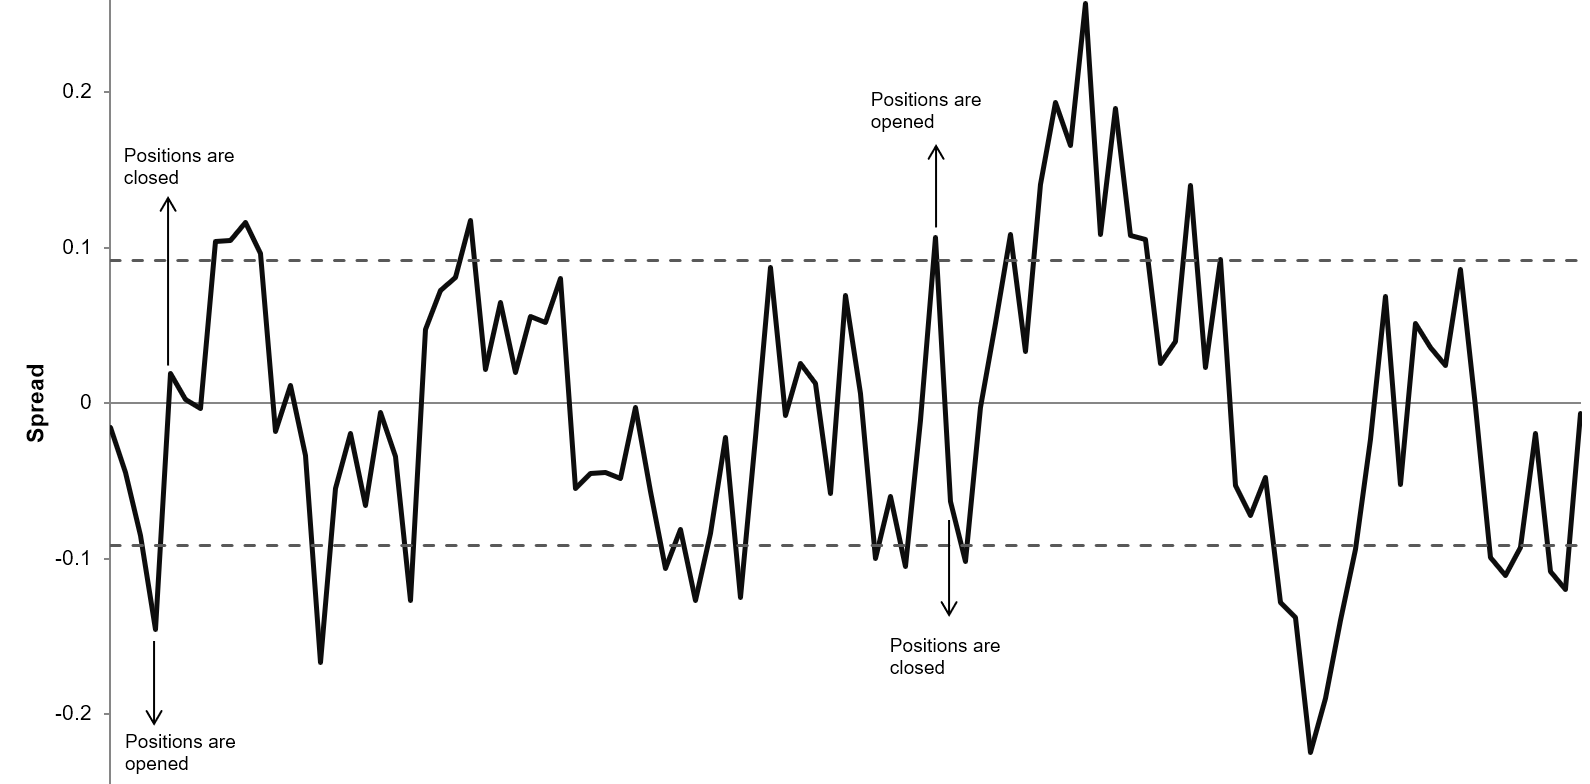

In [1]:
from PIL import Image
str_dir = 'D:/Estudos/2 Mestrado/Insper/Disciplinas/Finanças Quantitativas/Projeto/'
myImage = Image.open(str_dir + 'Figura_Pairs_Trading.png')
myImage

## Bibliotecas

Abaixo estão todas as bibliotecas utilizadas no código.

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import seaborn as sns

## Configurações

As configurações necessárias às bibliotecas empregadas no modelo estão consolidadas abaixo.

In [3]:
# Comando para que os gráficos sejam exibidos no corpo do texto
%matplotlib inline

In [4]:
plt.rcParams['figure.dpi'] = 200 # Resolução dos gráficos impressos no pdf (dpi)

In [5]:
# Estilo dos gráficos
sns.set(color_codes = True)

## Parâmetros

Esses são os parâmetros referentes aos modelos de pairs trading que são implementados no código, a serem detalhados mais a frente.

In [6]:
alfa = 0.01 # Nível de significância utilizado nos testes de hipótese 
janela_dados = 252 # tamanho da janela de dados utilizada para estimação dos modelos
janela_coint = 5 # janela de dias que será analisada para determinação da cointegração das ações de um par
cost = 0 # custo de execução 
th_KF = 0.25 # Número de desvios-padrão de distância da média para abertura de posição usando KF
delta_beta_lim = 0 #variável para reduzir a frequência de ajustes de posição

## Importação e Tratamento dos Dados

In [7]:
# Leitura da planilha com as séries de preços diários das ações de cada par

str_plan_bd_stocks = 'BD_Stocks_v4'

df_prices = pd.read_csv(filepath_or_buffer = str_dir + str_plan_bd_stocks + '.csv', sep=';')
df_prices.index = df_prices['Dates']
df_prices.index = pd.to_datetime(df_prices['Dates'])
df_prices = df_prices.drop(columns=['Dates'])
df_prices = df_prices.dropna()

In [8]:
# Log preços - serão usados nos testes de cointegração
df_log_prices = np.log(df_prices)
df_log_prices.head()

,PETR3 BZ Equity,PETR4 BZ Equity
Dates,,
2008-01-02,3.954220,3.772761
2008-01-03,3.939638,3.756538
2008-01-04,3.878466,3.706228
2008-01-07,3.843530,3.676427
2008-01-08,3.901973,3.729901


## Cálculo dos Spreads

### Regressão Usando Filtro de Kalman

A função abaixo implementa a regressão do log preço de uma ação contra o log preço da outra ação do par utilizando o filtro de Kalman. Ela retorna os coeficientes estimados ao longo do tempo, o resíduo (spread), as matrizes de covariância dos coeficientes e um objeto contendo o filtro de Kalman ajustado.

Essa função é empregada na função spread_KF para computar o spread de cada par de ações da base.

In [9]:
'''Parâmetros da função:
-> y, x : log preços do par de ações.
-> delta: parâmetro relacionado à variância. Quanto mais próximo de 1, mais voláteis são os betas, melhor o ajuste
porém pior a capacidade preditiva do filtro. Quanto mais próximo de zero, mais estáveis são os betas, porém a capacidade 
preditiva é ruim. Há então um ponto ótimo no meio desse intervalo. 
-> obs_cov: matriz de covariância das observações - variáveis de estado.
-> init_mean, init_cov: são os valores iniciais da média e da matriz de covariância dos betas para inicialização do filtro.
-> intercept: se você deseja rodar regressão com (TRUE) ou sem (FALSE) intercepto.
-> em: se você deseja utilizar o algoritmo "em" para estimar os valores iniciais da média e da matriz de covariância dos betas.
''' 

def KFReg(y, x, delta, obs_cov, init_mean, init_cov, intercept = False, em = False):
    if intercept == True: #caso regressão utilize intercepto
        obs_mat = np.vstack([x, np.ones(x.shape)]).T[:, np.newaxis] 
        if em == False:
            trans_cov = delta / (1 - delta) * np.eye(2)
            kf = KalmanFilter(n_dim_obs = 1, 
                              n_dim_state = 2, 
                              initial_state_mean = init_mean,
                              initial_state_covariance = init_cov,
                              transition_matrices = np.eye(2), # Essa é a matriz que define o random walk
                              observation_matrices = obs_mat,
                              observation_covariance = obs_cov,
                              transition_covariance = trans_cov)
            state_means, state_covs = kf.filter(y.values)
        else:
            kf = KalmanFilter(n_dim_obs = 1, 
                              n_dim_state = 2, 
                              initial_state_mean = init_mean, 
                              initial_state_covariance = init_cov,
                              observation_matrices = obs_mat)
            state_means, state_covs = kf.filter(y.values)
        beta0 = state_means[:,1]
        beta1 = state_means[:,0]
        resid = y - beta0 - beta1*x
        return beta0, beta1, resid, state_covs, kf
    else:
        obs_mat = np.vstack([x]).T[:, np.newaxis]
        if em == False:
            trans_cov = delta / (1 - delta)
            kf = KalmanFilter(n_dim_obs = 1, 
                              n_dim_state = 1, 
                              initial_state_mean = init_mean,
                              initial_state_covariance = init_cov,
                              transition_matrices = 1,
                              observation_matrices = obs_mat,
                              observation_covariance = obs_cov,
                              transition_covariance = trans_cov)
            state_means, state_covs = kf.filter(y.values)
        else:
            kf = KalmanFilter(n_dim_obs = 1, n_dim_state = 1, 
                              initial_state_mean = init_mean, 
                              initial_state_covariance = init_cov,
                              observation_matrices = obs_mat)
            state_means, state_covs = kf.em(y.values).filter(y.values)
        beta1 = state_means[:,0]
        resid = y - beta1*x
        return beta1, resid, state_covs, kf

### Cálculo do Spread Usando Filtro de Kalman

In [10]:
# Os parâmetros são os mesmos utilizados na função da regressão do filtro de Kalman, com exceção de:
# janela_dados: define o tamanho da janela móvel

def spread_KF(log_price1, log_price2, janela_dados, delta, obs_cov, init_mean0, init_cov, intercept = False, em = False):
    
    y = log_price1
    x = log_price2
    T = len(y)
    
    s = pd.DataFrame(np.NaN, index = y.index, columns = ['Spread'])
    adf_res = pd.DataFrame(np.NaN, index = np.arange(0,T), columns = ['ADF'])
    beta0 = pd.DataFrame(np.NaN, index = np.arange(0,T), columns = ['Beta0'])
    beta1 = pd.DataFrame(np.NaN, index = np.arange(0,T), columns = ['Beta1'])
    
    inicio = 0
    fim = janela_dados
    i = 0
    init_mean = init_mean0
    
    while fim <= T:
        
        x_array = x.iloc[np.arange(inicio,fim)]
        y_array = y.iloc[np.arange(inicio,fim)]
        res = KFReg(y = y_array, x = x_array, 
                    delta = delta, obs_cov = obs_cov, 
                    init_mean = init_mean, init_cov = init_cov, 
                    intercept = intercept, em = em)
        if intercept == False:
            beta1.iloc[np.arange(inicio,fim),:] = pd.DataFrame(res[0]).values
            s.iloc[np.arange(inicio,fim),:] = pd.DataFrame(res[1]).values
            adf_res.iloc[fim-1,0] = 1*(adfuller(x = res[1], 
                                            regression = 'c', 
                                            autolag = 'BIC')[1] < alfa)
        else:
            beta0.iloc[np.arange(inicio,fim),:] = pd.DataFrame(res[0]).values
            beta1.iloc[np.arange(inicio,fim),:] = pd.DataFrame(res[1]).values
            s.iloc[np.arange(inicio,fim),:] = pd.DataFrame(res[2]).values
            adf_res.iloc[fim-1,0] = 1*(adfuller(x = res[2], 
                                            regression = 'c', 
                                            autolag = 'BIC')[1] < alfa)
        
        inicio = inicio + 1
        if intercept == False:
            init_mean = beta1.iloc[inicio,0]
        else:
            init_mean = np.array([beta1.iloc[inicio,0],
                                    beta0.iloc[inicio,0]])
        fim = fim + 1
        i = i + 1
    
    s = s.dropna()
    
    if intercept == False:
        return s, adf_res, beta1
    else:
        return s, adf_res, beta0, beta1

## Backtest

O objetivo dessa seção é efetuar um backtest da estratégia de pairs trading para verificação de seu retorno no período analisado. Para realização do backtest da estratégia, utilizaremos de um modelo de Thresholds com método de estimação via Filtro de Kalman (backtest_KF), que permite estimação diária dos coeficientes da regressão. 

Como preocupação para **não se utilizar de dados futuros** para a decisão de trading e cálculo dos retornos, foram **deslocados um dia para trás**:

**1.** A série de spread, que atua como sinal;

**2.** Os betas;

**3.** Os resultados dos testes de cointegração.

Tal regra pode ser observada nos índices dos dateframes que são percorridos nos loops - **ex:** fim_est-1 e fim_est-janela_coint-1.

 ### Função para Realização do Backtest Usando Filtro de Kalman e Threshold Predeterminados

#### Função que informa em que intervalo do spread se encontra

A função retorna a posição onde o spread se localiza, podendo retornar ao limite superior de cima, limite superior entre as bandas, limite inferior entre as banda e limite inferior de baixo.

Importante ressaltar que os resultados iniciais correspondentes a primeira janela móvel não são relevantes, pois, na função de backtest, onde os resultados serão utilizados, essa primeira janela não é levada em consideração, visto que o trade só começa após a mesma.

In [11]:
## A função retorna a posição onde o spread se localiza
## Limite superior de cima: resultado = 3
## Limite superior entre as bandas: resultado = 2
## Limite inferior entre as banda: resultado = 1
### Limite inferior de baixo: resultado = 0

def intervalos(df_spread, janela_dados, th):
    
    avg_spread = df_spread.rolling(window = janela_dados).mean()
    vol_spread = df_spread.rolling(window = janela_dados).std(ddof = 1)
                        
    lim_sup = avg_spread + th*vol_spread
    lim_inf = avg_spread - th*vol_spread
    
    resultado = (df_spread > lim_sup)*1 + (df_spread > avg_spread)*1 + (df_spread > lim_inf)*1

    return resultado

#### Função do Backtest

In [28]:
def backtest_KF(log_price1, log_price2, df_spread, df_interv, df_beta1, df_coint_res, 
                janela_dados, janela_coint, cost, delta_beta_lim):
    
    y = log_price1
    x = log_price2
    T = len(y)
    
    inicio_est = 2 # começa 2 para frente pois iremos aplicar um shift de 2 dias
    fim_est = janela_dados + 2 # notar que, pelo uso do np.arange, último dia eh fim_est - 1
    
    df_log_retornos = pd.DataFrame(np.NaN, index = y.index, columns = ['Retornos'])
    
    # Variável que informa se há posição aberta ou não
    par_aberto = False
    
    # -1 se o par foi aberto quando o spread estava na região inferior de fora
    # 1 se o par foi aberto quando o spread estava na região superior de fora
    
    pos_aberto = -1
    beta1_ant = df_beta1.iloc[fim_est-2,0]
    beta1 = df_beta1.iloc[fim_est-2,0]
    
    while fim_est < T:
        
        # Regra: se nos últimos (janela_coint) dias houver cointegração, então o par é negociado
        # inicio = fim_est - janela_coint
        # fim = fim_est - 1
        # tam = (fim_est - 1 - 1) - (fim_est - janela_coint - 1) + 1 = janela_coint
        if np.min(df_coint_res.iloc[np.arange(fim_est-janela_coint-1, fim_est-1), 0]) == True:
            
            # Acompanha a variação do beta de um dia para o outro para ajustar a posição de acordo
            # com a variação do beta
            if par_aberto == True:
                delta_beta = df_beta1.iloc[fim_est-2,0] - beta1
                if np.abs(delta_beta) > delta_beta_lim:
                    beta1_ant = beta1
                    beta1 = df_beta1.iloc[fim_est-2,0]
               
            # Caso 1: spread na parte superior de fora da banda
            if df_interv.iloc[fim_est-2,0] == 3:
                    
                # Caso 1.1: sem posição em aberto --> abre posição
                if par_aberto == False:
                    
                    beta1 = df_beta1.iloc[fim_est-2,0]
                    par_aberto = True
                    pos_aberto = 1
                    
                # Caso 1.2: com posição em aberto, pela parte superior --> mantém
                if par_aberto == True and pos_aberto == 1:
                    
                    cost_beta = np.abs(beta1 - beta1_ant)*cost/2
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                    
                # Caso 1.3: com posição em aberto, pela parte inferior --> fecha
                if par_aberto == True and pos_aberto == -1:
                    
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                    par_aberto = False
    
            # Caso 2: spread na parte superior de dentro da banda
            if df_interv.iloc[fim_est-2,0] == 2:
                
                # Caso 2.1: sem posição em aberto --> mantém
                if par_aberto == False:
                        
                    par_aberto = False
                    
                # Caso 2.2: com posição em aberto, pela parte superior --> mantém
                if par_aberto == True and pos_aberto == 1:
                        
                    cost_beta = np.abs(beta1 - beta1_ant)*cost/2
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                    
                # Caso 2.3: com posição em aberto, pela parte inferior --> fecha
                if par_aberto == True and pos_aberto == -1:
                        
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                    par_aberto = False
                
            # Caso 3: spread na parte inferior de dentro da banda
            if df_interv.iloc[fim_est-2,0] == 1:
                    
                # Caso 3.1: sem posição em aberto --> mantém
                if par_aberto == False:
                        
                    par_aberto = False
                    
                # Caso 3.2: com posição em aberto, pela parte superior --> fecha
                if par_aberto == True and pos_aberto == 1:
                        
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                    par_aberto = False
                    
                # Caso 3.3: com posição em aberto, pela parte inferior --> mantém
                if par_aberto == True and pos_aberto == -1:
                        
                    cost_beta = np.abs(beta1 - beta1_ant)*cost/2
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                
            # Caso 4: spread na parte inferior de fora da banda
            if df_interv.iloc[fim_est-2,0] == 0:
        
                # Caso 4.1: sem posição em aberto --> abre
                if par_aberto == False:
                        
                    beta1 = df_beta1.iloc[fim_est-2,0]
                    par_aberto = True
                    pos_aberto = -1
                    
                # Caso 4.2: com posição em aberto, pela parte superior --> fecha
                if par_aberto == True and pos_aberto == 1:
                        
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                    par_aberto = False
                    
                # Caso 4.3: com posição em aberto, pela parte inferior --> mantém
                if par_aberto == True and pos_aberto == -1:
                        
                    cost_beta = np.abs(beta1 - beta1_ant)*cost/2 
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                
        # Else para contemplar o caso no qual, no período anterior, havia cointegração e foi terminado
        # com posição em aberto, que será fechada imediatamente no período seguinte se não houver cointegração
        else:
            
            if par_aberto == True:
                    
                if pos_aberto == 1:
                        
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost 
                    
                if pos_aberto == -1:
                
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                
                par_aberto = False
                
        inicio_est = inicio_est + 1
        fim_est = fim_est + 1
        
    return df_log_retornos

## Exemplo de Pair Trading - PETR3 x PETR4

Nessa sessão realizamos um exemplo de implementação da estratégia de pairs trading com cointegração, utilizando os spreads calculados pelo filtro de Kalman e adotando um modelo de thresholds para regrar a negociação do par. Para esta análise foi utilizado o par de ações PETR3 e PETR4, papéis da mesma empresa e que possuem alta correlação entre si. Ao final, também foi construído um gráfico de retornos acumulados da estratégia para ilustrar o desempenho desta.

#### Cálculo do Retorno Acumulado para as Séries de Preço

In [13]:
# Cálculo do retorno acumulado para as séries de preço
x = df_log_prices['PETR4 BZ Equity']
x = x.diff()
x[0] = 0 #Para casos de não intercepto na regressão do filtro de Kalman, as séries de preço são normalizadas começando em zero
x = x.cumsum()
y = df_log_prices['PETR3 BZ Equity']
y = y.diff()
y[0] = 0 #Para casos de não intercepto na regressão do filtro de Kalman, as séries de preço são normalizadas começando em zero
y = y.cumsum()

#### Cálculo do Spread das Séries de Preço usando Filtro de Kalman

Foi utilizado Filtro de Kalman como intercepto, em concordância com o modelo que foi apresentado na introdução.

In [14]:
# Cálculo do spread usando KF com intercepto
# Valores calibrados empiricamente
res_KF = spread_KF(y, x, janela_dados, 
                delta = 1e-2, obs_cov = 0.25, 
                init_mean0 = np.array([1,0]), init_cov = np.matrix([[0.25,0],[0,0.25]]), 
                intercept = True, em = False)

#### Variáveis que Guardam Resultados do Cálculo do Spread

In [15]:
# Variáveis que guardam os resultados do cálculo do spread usando KF
s_KF = res_KF[0]
adf_KF = res_KF[1]
beta_KF = res_KF[3]

In [35]:
interv_KF = intervalos(s_KF, janela_dados, th_KF)

#### Implementação da Função de Backtest

In [36]:
df_log_retornos_KF_th = backtest_KF(y, x, s_KF, interv_KF, beta_KF, adf_KF, 
                                    janela_dados, janela_coint, cost, delta_beta_lim)

#### Gráfico dos Retornos Acumulados da Estratégia

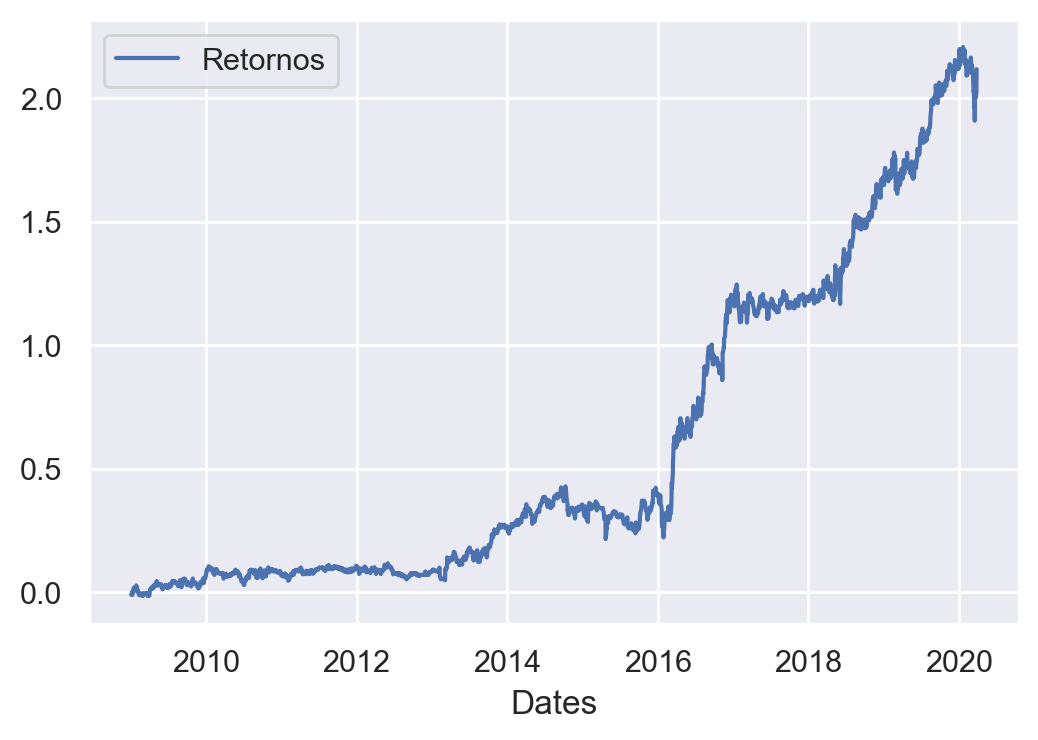

In [37]:
sns.lineplot(data=np.exp(df_log_retornos_KF_th.cumsum())-1)

## Referências Bibliográficas

CALDEIRA, J. F.; MOURA, G. V. Selection of a portfolio of pairs based in cointegration: A statistical arbitrage strategy. Revista Brasileira de Finanças, v. 11, n. 1, p. 49-80, mar. 2013.

CARHART, M. M., On persistence in mutual fund performance. Journal of Finance, v. 52, n. 1, p. 57-82, mar. 1997.

FAMA, E. F., FRENCH, K. F., Common risk factors in the returns on stocks and bonds. Journal of Financial Economics, v.33, n.1, p. 3-56, fev. 1993.

GATEV, E., $et.$ $al$. Pairs trading: performance of a relative-value arbitrage rule. Review of Financial Studies, v. 19, n. 3, p. 797-827, mar. 2006.